### **import important libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [2]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **read data**

In [3]:
path = 'IMDB_Dataset.csv'
data = pd.read_csv(path)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### **statistical analysis**

In [4]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


<Axes: xlabel='sentiment', ylabel='count'>

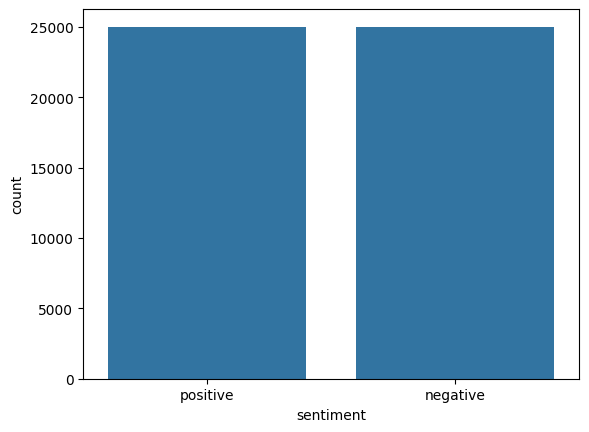

In [5]:
sns.barplot(data.sentiment.value_counts())

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### **text preprocessing**

In [7]:
stop_words = set(stopwords.words('english'))
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def remove_special_characters(review):
    """
    Remove Special character
    with regular expression ==> [^a-zA-Z0-9\s]
    """
    return re.sub(r"[^a-zA-Z0-9\s]", '', review)

def remove_html_tags(review):
    """
    remove html tags using BeautifulSoup
    and use lxml library as a backend parser
    """
    return BeautifulSoup(review, 'lxml').get_text()

def clean_text(review):
    """
    Clean the review text:
    - Remove HTML tags
    - Remove special characters
    - Convert to lowercase
    """
    # Remove HTML tags using BeautifulSoup
    review = remove_html_tags(review)
    # Remove special characters and numbers
    review = remove_special_characters(review)
    # Convert to lowercase and strip spaces
    review = review.lower().strip()
    
    return review

def remove_stopwords(text, stop_words):
    """
    Remove stop words from the text.
    """
    return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

def apply_stemming(text, stemmer):
    """
    Apply stemming to reduce words to their root form.
    """
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

def apply_lemmatizing(text, lemmatizer):
    """
    Apply stemming to reduce words to their root form.
    """
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

def preprocess_review(review):
    review = clean_text(review)
    review = remove_stopwords(review, stop_words)
    review = apply_lemmatizing(review, lemmatizer)
    return review


In [9]:
%%time
data['review'] = data['review'].apply(preprocess_review)
data

CPU times: total: 1min 41s
Wall time: 1min 41s


,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,im going disagree previous comment side maltin...,negative


### **Split data to train, test, and validation**

In [10]:
X = data['review']
y = data['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### **Encode target labels**

In [11]:
y_train = y_train.map({'positive': 1, 'negative': 0})
y_val = y_val.map({'positive': 1, 'negative': 0})
y_test = y_test.map({'positive': 1, 'negative': 0})

### **Lexicon-based Approach**

##### **Random Forest Model**

###### **convert data to vector**

In [13]:
count_vectorizer_rf = CountVectorizer(analyzer='word')
tfidf_vectorizer_rf = TfidfVectorizer(analyzer='word')

In [14]:
X_train_count_vec_rf = count_vectorizer_rf.fit_transform(X_train)
X_test_count_vec_rf = count_vectorizer_rf.transform(X_test)
X_val_count_vec_rf = count_vectorizer_rf.transform(X_val)

In [15]:
X_train_tfidf_vec_rf = tfidf_vectorizer_rf.fit_transform(X_train)
X_test_tfidf_vec_rf = tfidf_vectorizer_rf.transform(X_test)
X_val_tfidf_vec_rf = tfidf_vectorizer_rf.transform(X_val)

###### **I can't convert sparse matrix to dense array**
###### **because it will give me memory error because my system can't alocate (40000, 138427) and data type int64**

In [16]:
# df_countvec = pd.DataFrame(data=X_train_count_vec.toarray(), columns=count_tokens)
# df_tfidfvec = pd.DataFrame(data=X_train_tfidf_vec.toarray(), columns=tfidf_tokens)

###### **train random forest classifier**

In [17]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_count_vec_rf, y_train)

val_accuracy = rf_model.score(X_val_count_vec_rf, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 0.85


###### **evalute model**

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      2500
           1       0.85      0.86      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



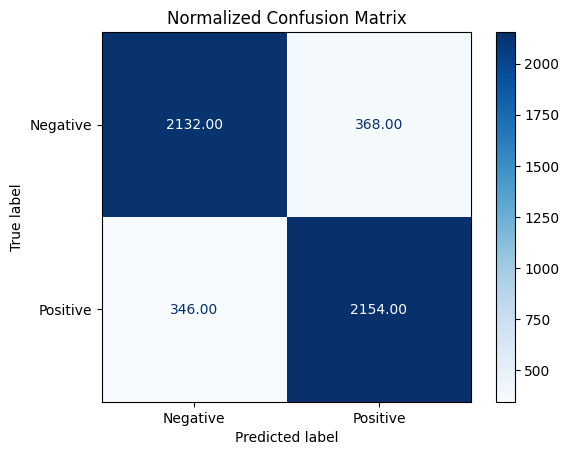

In [18]:
y_test_pred = rf_model.predict(X_test_count_vec_rf)
cm = confusion_matrix(y_test, y_test_pred)
# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_test_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

###### **hyperparameter tuning**

###### **param distributions**

In [ ]:
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

###### **Create the RandomizedSearchCV object**

In [19]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),  # Base model
    param_distributions=param_distributions,           # Hyperparameter grid
    n_iter=5,                 # Number of random combinations to try
    cv=5,                      # 5-fold cross-validation
    n_jobs=-1,                 # Use all available CPUs
    verbose=2,                 # Verbosity level
    random_state=42            # For reproducibility
)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best Cross-Validation Score: 0.858125


###### **train model on count vectorizered data**

In [ ]:
# Fit RandomizedSearchCV on your training data
random_search.fit(X_train_count_vec_rf, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)
# Best parameters and model
print("Best Parameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_

###### **evalute model**

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      2500
           1       0.86      0.88      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



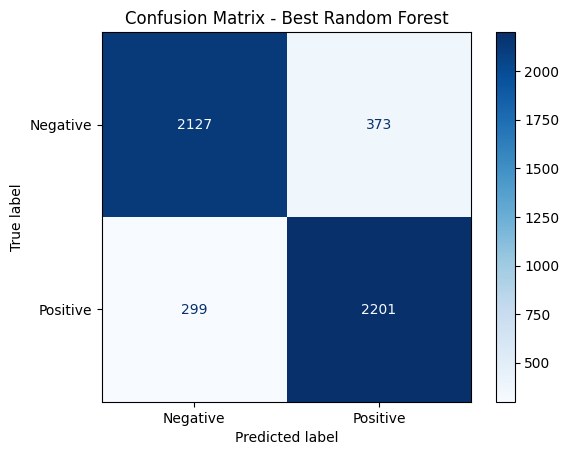

In [21]:
y_test_pred = best_rf_model.predict(X_test_count_vec_rf)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best Random Forest")
plt.show()

###### **train model tfidf vectorizered data**

In [ ]:
random_search.fit(X_train_tfidf_vec_rf, y_train)
print("Best Parameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_
y_test_pred = best_rf_model.predict(X_test_tfidf_vec_rf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


###### **evaluate model**

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      2500
           1       0.85      0.86      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



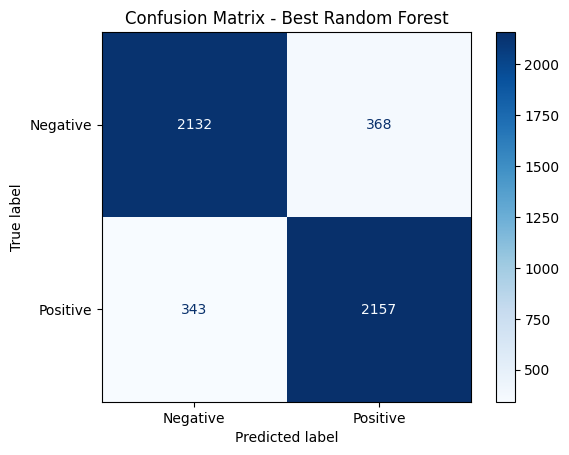

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best Random Forest")
plt.show()

#### **logistic regression model**